In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## install libs

In [3]:
pip install torch==2.2.0 torchaudio==2.4.0 captum==0.7.0 matplotlib==3.7.2 torchview==0.2.6 graphviz==0.20.3

  Using cached torch-2.2.0-cp312-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached torchaudio-2.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached matplotlib-3.7.2.tar.gz (38.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.2.0 and torchaudio==2.4.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.2.0
    torchaudio 2.4.0 depends on torch==2.4.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dea

In [270]:
#!brew install -y graphviz

## imports

In [5]:
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## set randomness seed for reproducibility

In [7]:
torch.manual_seed(101)

## define dataset object

In [9]:
# Custom Dataset class to handle audio loading and MFCC extraction
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['real', 'fake']
        self.data = []
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(class_dir, file_name)
                    self.data.append((file_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if self.transform:
            mfcc = self.transform(waveform)  # MFCC extraction
        label = self.classes.index(label)  # Convert label to integer (0 or 1)
        return mfcc.transpose(1, 2).squeeze(), label  # Transpose to [n_mels, time_steps] -> [time_steps, n_mels]

## define model (transformer) architecture

In [308]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels, n_classes=2, nhead=1, num_encoder_layers=1, dim_feedforward=64, dropout=0.1):
        super(AudioTransformer, self).__init__()
        
        self.n_mels = n_mels
        self.positional_encoding = nn.Parameter(self.create_positional_encoding(1000, n_mels), requires_grad=False)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_mels, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.fc = nn.Linear(n_mels, n_classes)

    def create_positional_encoding(self, length, dim):
        pe = torch.zeros(length, dim)
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        # Dynamically resize positional encoding to match input length
        seq_length = x.size(1)
        x = x + self.positional_encoding[:, :seq_length, :].to(x.device)
        
        # Pass through the transformer encoder
        x = self.transformer_encoder(x)
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Classification layer
        x = self.fc(x)
        
        return x

#### number of parameters in the model

In [310]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioTransformer(n_mels=N_MFCC, n_classes=2).to(device)
print("num_parameters:", sum([len(x) for x in model.parameters()]))

num_parameters: 413


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## load and transform datasets (train, validation, and test sets)

#### check waveform shape

In [74]:
waveform, sample_rate = torchaudio.load('for-2seconds/training/fake/file10005.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav')

In [292]:
print(waveform.shape, sample_rate)

torch.Size([1, 32000]) 16000


### create train validation and test dataset and dataloader objects

In [14]:
melkwargs = {"hop_length": 200, "n_mels": 20}
# Transform: Extract MFCC features
N_MFCC=20
transform = transforms.MFCC(
    sample_rate=16000, 
    n_mfcc=N_MFCC,         # Number of MFCC coefficients (matches your transformer's d_model)
    melkwargs=melkwargs
)


train_dataset = AudioDataset(root_dir='/Users/ashish/Downloads/for-2seconds/training/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AudioDataset(root_dir='/Users/ashish/Downloads/for-2seconds/validation/', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = AudioDataset(root_dir='/Users/ashish/Downloads/for-2seconds/testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## visualize data samples

#### check shape of a single data sample

In [102]:
data_sample = train_dataset[0]
print(data_sample[0].shape)

torch.Size([161, 20])


#### plot MFCCs

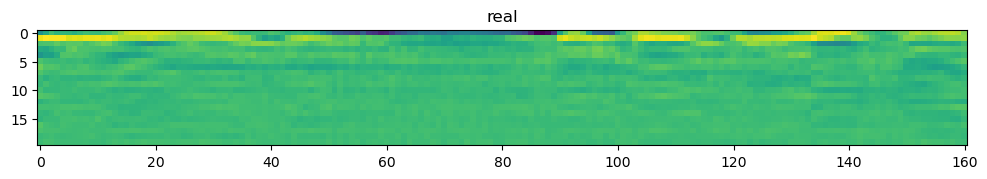

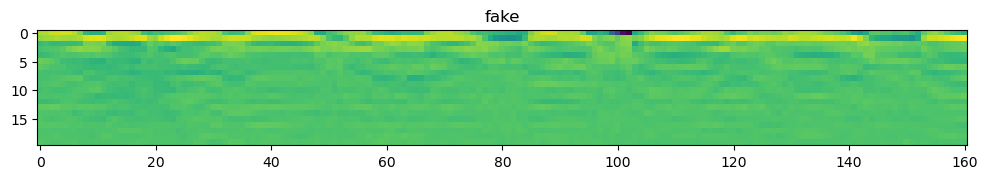

In [112]:
for idx in [0, -1]: # pick the first and the last sample of training data
    plt.figure(figsize = (12,10))
    plt.imshow(train_dataset[idx][0].T);
    plt.title({0: "real", 1: "fake"}.get(train_dataset[idx][1]))

#### visualize MFCCs with positional encoding

Text(0.5, 1.0, 'raw input + position_encoding')

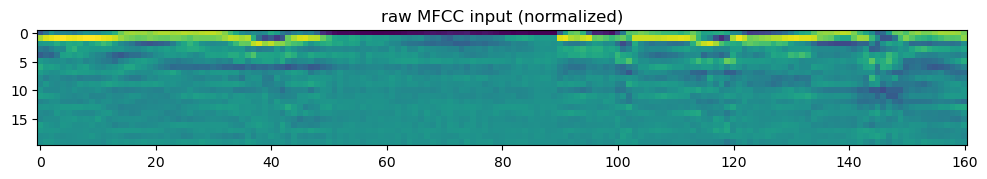

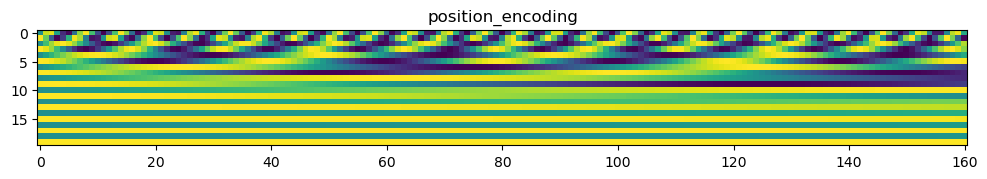

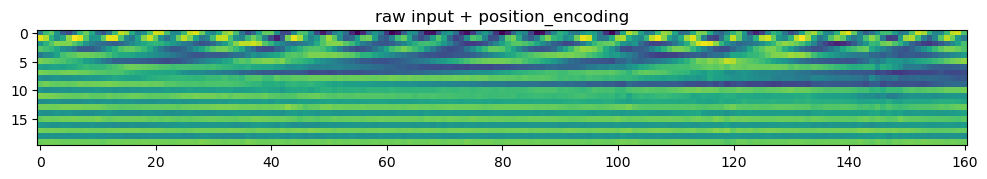

In [378]:
raw_input = torch.nn.functional.normalize(train_dataset[0][0])
positional_encoding = model.positional_encoding[0][:len(raw_input)]

plt.figure(figsize = (12,10))
plt.imshow(raw_input.T);
plt.title("raw MFCC input (normalized)")
plt.figure(figsize = (12,20))
plt.imshow(positional_encoding.T);
plt.title("position_encoding")
plt.figure(figsize = (12,20))
plt.imshow((raw_input+positional_encoding).T);
plt.title("raw input + position_encoding")

## instantiate and train model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AudioTransformer(n_mels=N_MFCC, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1], dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total} %')

Epoch 1/10, Loss: 0.4808702190967119
Validation Accuracy: 82.66100495399859 %
Epoch 2/10, Loss: 0.31091769075434594
Validation Accuracy: 87.22576079263978 %
Epoch 3/10, Loss: 0.22882688481113458
Validation Accuracy: 87.79193205944799 %
Epoch 4/10, Loss: 0.18032589509605815
Validation Accuracy: 92.00283085633404 %
Epoch 5/10, Loss: 0.13522554368411513
Validation Accuracy: 92.7105449398443 %
Epoch 6/10, Loss: 0.11160879993909284
Validation Accuracy: 94.90445859872611 %
Epoch 7/10, Loss: 0.09547844580300067
Validation Accuracy: 90.7997169143666 %
Epoch 8/10, Loss: 0.0824930993872066
Validation Accuracy: 93.59518754423213 %
Epoch 9/10, Loss: 0.07479712708365147
Validation Accuracy: 94.93984430290163 %
Epoch 10/10, Loss: 0.07597392483122084
Validation Accuracy: 96.7445152158528 %


## visualize model architecture

In [266]:
from torchview import draw_graph
model_graph = draw_graph(model.transformer_encoder.layers[0], input_size=(1, 1000, 20), device='meta', 
                         save_graph=1, depth=1, strict=0, graph_dir="TB", 
                         expand_nested=1, roll=0)
m = model_graph.visual_graph

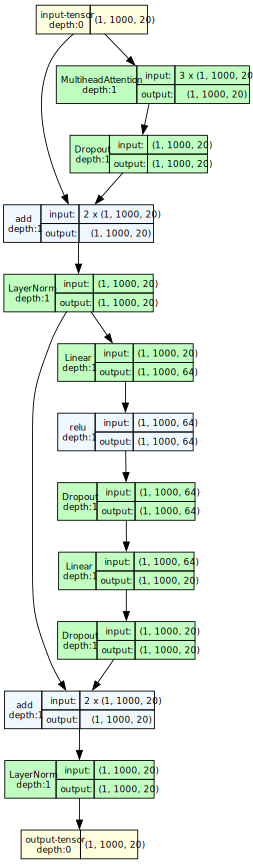

In [268]:
m

In [216]:
m.render(format='svg', )

'model.gv.svg'

## test trained model

In [23]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total} %')

Test Accuracy: 69.48529411764706 %


## save trained model

In [25]:
torch.save(model.state_dict(), 'audio_classification_model.pth')

## load saved model

In [316]:
model = AudioTransformer(n_mels=N_MFCC, n_classes=2).to(device)
model.load_state_dict(torch.load('audio_classification_model.pth'))

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/var/folders/4v/h808km254mb5ws5bw0w90t240000gn/T/ipykernel_73530/333483820.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

<All keys matched successfully>

In [392]:
model

AudioTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=20, out_features=2, bias=True)
)

## run prediction on unseen data (genuine audio sample)

In [28]:
import torchaudio
import torch
import torchaudio.transforms as transforms

def preprocess_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Convert to mono if the audio has multiple channels
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample to 16000 Hz if necessary
    if sample_rate != 16000:
        resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resample_transform(waveform)
    
    # Extract MFCCs
    mfcc_transform = transforms.MFCC(
        sample_rate=16000, 
        n_mfcc=N_MFCC, 
        melkwargs=melkwargs
    )
    mfcc = mfcc_transform(waveform)
    
    # Transpose to [time_steps, n_mels] for transformer input
    mfcc = mfcc.squeeze(0).transpose(0, 1)  # Squeeze channel and transpose

    # Return the tensor on the specified device, with an added batch dimension
    return mfcc.unsqueeze(0).to(device)  # Shape [1, time_steps, n_mels]

The model predicts the audio is: fake


## try an unseen real audio sample

In [380]:
K = 1000
new_audio_file = '/Users/ashish/Downloads/archive_1/KAGGLE/AUDIO/REAL/ryan-original.wav'
input_tensor = preprocess_audio(new_audio_file)
for i in range(len(input_tensor[0])//K):
    print(f"Input part {i}")
    with torch.no_grad():
        output = model(input_tensor[:, i*K:(i+1)*K, :])
        _, predicted = torch.max(output, 1)

    classes = ['real', 'fake']
    predicted_label = classes[predicted.item()]

    print(f"The model predicts the audio is: {predicted_label}")

Input part 0
The model predicts the audio is: real
Input part 1
The model predicts the audio is: real
Input part 2
The model predicts the audio is: real
Input part 3
The model predicts the audio is: real
Input part 4
The model predicts the audio is: real
Input part 5
The model predicts the audio is: real
Input part 6
The model predicts the audio is: real


## try an unseen fake audio sample

In [382]:
K = 1000
new_audio_file = '/Users/ashish/Downloads/archive_1/KAGGLE/AUDIO/FAKE/ryan-to-margot.wav'
input_tensor = preprocess_audio(new_audio_file)
for i in range(len(input_tensor[0])//K):
    print(f"Input part {i}")
    with torch.no_grad():
        output = model(input_tensor[:, i*K:(i+1)*K, :])
        _, predicted = torch.max(output, 1)

    classes = ['real', 'fake']
    predicted_label = classes[predicted.item()]

    print(f"The model predicts the audio is: {predicted_label}")

Input part 0
The model predicts the audio is: fake
Input part 1
The model predicts the audio is: real
Input part 2
The model predicts the audio is: fake
Input part 3
The model predicts the audio is: fake
Input part 4
The model predicts the audio is: fake
Input part 5
The model predicts the audio is: fake
Input part 6
The model predicts the audio is: fake
